# Movie data analysis between genre and profit ratio

The movie business might look pretty glamorous and lucrative. We wanted to take a look at the profit ratios of major genres around the world relative to their global average popularity to determine which genres are the most profitable. I also think that genre is important for any studio creating a new movie. If we investigate this data, we can infer what genre is the best for the audience. I wanted to use this dataset to get a deeper understanding of profit ratio between different genres. I will be performing ANOVA and t-tests between the genres and profit ratio.

## Part 1: Preparing data

In [1]:
#import library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import seaborn as sns
import zipfile
import statsmodels.api as sm
from statsmodels.formula.api import ols
sns.set()

In [10]:
import os
print(os.getcwd())

C:\Users\thivnguyen\Git\Flatiron\CapStoneProject\personal_notebooks


In [11]:
#read data
movie_budgets =pd.read_csv('../zippedData/tn.movie_budgets.csv.gz')
zip_file = "../zippedData/im.db.zip"

try:
    with zipfile.ZipFile(zip_file, 'r') as z:
        z.extractall("zippedData/unZippedim.db")
        print("Extracted all")
except:
    print("Invalid file")
conn = sqlite3.connect("zippedData/unZippedim.db/im.db")
##change trelease_date object type to datetime type
movie_budgets["release_date"] = pd.to_datetime(movie_budgets["release_date"])
#movie_budgets.info()\
#clean movie_budget dataset
def clean_currency(x):
    """ If the value is a string, then remove currency symbol and delimiters
    otherwise, the value is numeric and can be converted
    """
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)

movie_budgets['production_budget'] = movie_budgets['production_budget'].apply(clean_currency).astype('float64')
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].apply(clean_currency).astype('float64')
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].apply(clean_currency).astype('float64')


Extracted all


In [13]:
q1= """
SELECT * 
FROM movie_basics
INNER JOIN movie_ratings
USING("movie_id")
INNER JOIN movie_akas
USING("movie_id")
"""
sql_dataset_merge1 = pd.read_sql(q1,conn)
#find and remove duplicate rows across'movie_id', 'title', 'start_year' columns 
duplicateRows = sql_dataset_merge1[sql_dataset_merge1.duplicated(['movie_id','title', 'start_year'])]
data1= sql_dataset_merge1.drop(duplicateRows.index,axis=0)
#create new "release_year" column for merging 2 datatset
movie_budgets['release_year']= movie_budgets['release_date'].dt.year
##merge 2 dataset by using title and released year
merge_data= movie_budgets.merge(data1, how= 'inner', left_on=['movie','release_year'], right_on= ['title','start_year'])
dataset= merge_data[[ 'release_date', 'movie', 'production_budget',
       'domestic_gross', 'worldwide_gross',
       'start_year',
       'runtime_minutes', 'genres']]
#drop 7 rows with NA
dataset=dataset.dropna()
## calulate profit by subtracting gross and budget  by subtracting gross and budget domestic_gross
dataset['profit']= dataset['worldwide_gross']- dataset['production_budget']
##calulate profit ratio
dataset['profit_ratio'] = (dataset['profit'] - dataset['production_budget'])/ dataset['production_budget']

## top 5 greatest profit ratio 
dataset.sort_values(['profit_ratio'], ascending=False).head()

##this code check which movies in specific genre
#dataset[dataset['genres']. str.contains("Drama")]

,release_date,movie,production_budget,domestic_gross,worldwide_gross,start_year,runtime_minutes,genres,profit,profit_ratio
1565,2015-07-10,The Gallows,100000.0,22764410.0,41656474.0,2015,81.0,"Horror,Mystery,Thriller",41556474.0,414.564740
1465,2012-01-06,The Devil Inside,1000000.0,53262945.0,101759490.0,2012,83.0,Horror,100759490.0,99.759490
1338,2010-10-20,Paranormal Activity 2,3000000.0,84752907.0,177512032.0,2010,91.0,Horror,174512032.0,57.170677
1242,2017-02-24,Get Out,5000000.0,176040665.0,255367951.0,2017,104.0,"Horror,Mystery,Thriller",250367951.0,49.073590
1436,2016-10-21,Moonlight,1500000.0,27854931.0,65245512.0,2016,111.0,Drama,63745512.0,41.497008


The dataset contain 1581 movies after 2010. Each movie include 1 main genre and up to 2 sub-genres. After exploring the dataset, I found that action is the most expensive genre with the high budget. It makes sense because action films take longer to shoot and build intense sequences that put people in danger to draw the attention of audience. Therefore, action movies bring low profit ratio returns. On the other side, horror movies are typically low budget with high profit ratios and have some extreme examples of profit ratio such as The Gallow (2015), The Devil Inside (2012), etc.


I want to split up the genres column cells so we can tally each genre individually. Next I'll remove the 'genres' column (with multiple values) and replace it with a 'genre' column (with single values). Then I'll make sure that there is a new row for each genre, so there will be multiple rows with the same movie_title.



In [14]:

df_split_genre = dataset.copy()
# limit data to 2010-present
df_split_genre = df_split_genre.loc[df_split_genre['release_date'].dt.year >= 2010]
split_genre = df_split_genre['genres'].str.split(',').apply(pd.Series, 1).stack().reset_index(level=1, drop=True)
split_genre.name = 'genre_split'
df_split_genre = df_split_genre.drop(['genres'], axis=1).join(split_genre)
##remove outlier with only 1 movie genre which is News
df_split_genre= df_split_genre[df_split_genre['genre_split']. str.contains("News")== False]
##differrence genre in the dataset
#df_split_genre['genre_split'].unique()

## Visualize dataset

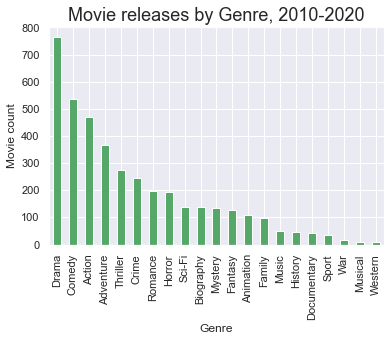

In [15]:
##histogram
df_split_genre['genre_split'].value_counts().plot(kind='bar', color='g');
plt.title('Movie releases by Genre, 2010-2020', size=18)
plt.xlabel('Genre', size=12)
plt.ylabel('Movie count', size=12);

In terms of the number of releases worldwide, dramas, comedies, and action topped the list between 2010 and 2020, with nearly 500 action films, more than 500 comedy films, and over 700 drama films released during that period. This means that the public currently loves these genres more than the other. It doesn't mean that these films will bring a return on investment, however. The success comes at a cost because these genres require a lot of elements such as big stars, high buget, so on.

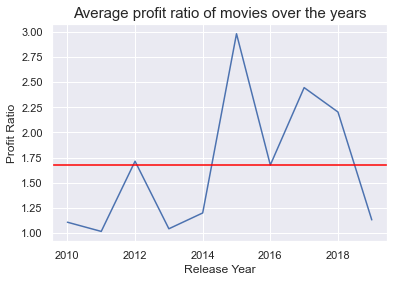

In [16]:
df_split_genre['start_year']= df_split_genre['release_date'].dt.year
gross_mean= df_split_genre.groupby(dataset['start_year'])['profit_ratio'].mean()
#print(gross_mean)
plt.plot(gross_mean)
plt.axhline(df_split_genre['profit_ratio'].mean(), color ='red')
plt.title('Average profit ratio of movies over the years', size=15);
plt.xlabel('Release Year', size=12)
plt.ylabel('Profit Ratio', size=12)
plt.legend;

We could see the average profit ratio tended to go up but the trend reversed significantly after 2018 because of the economic impact of Covid-19. The red line shows the average profit ratio over the years, which is 1.7. This mean that it is not easy to make a film which will make money.

## Hypothesis testing

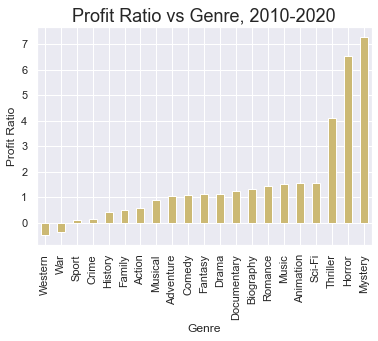

In [17]:
#tranform data set to keep only genre and profit ratio
profit_ratio_genre=df_split_genre.groupby('genre_split')['profit_ratio'].mean().sort_values()
genre_profit=df_split_genre[['genre_split','profit_ratio']].sort_values('genre_split').reset_index(level=0, drop=True)
profit_ratio_genre=df_split_genre.groupby('genre_split')['profit_ratio'].mean().sort_values()
profit_ratio_genre.plot(kind='bar', color='y');
plt.title('Profit Ratio vs Genre, 2010-2020', size=18)
plt.xlabel('Genre', size=12)
plt.ylabel('Profit Ratio', size=12);

It is clear that **mystery, horror, and thriller** are the top 3 genres with respect to profit ratio. These genres have a common and dedicated audience. This mean that as long as you have something to deliver on it (for example, if you do a haunting movie the ghost has to be scary or if you do a thriller, the movie has to be sufficiently exciting), the audience doesn't care a lot about the choice of actors or actress reputation. I would recommend that if you starting making films, these genres are good way to make money.  
Next, I used a one-way ANOVA to determine whether there are any statistically significant differences between the means of profit ratio in different genres.

In [18]:


# Ordinary Least Squares (OLS) model
model = ols('profit_ratio ~ C(genre_split)', data=genre_profit).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table
# display model summary
#print(model.summary())

,sum_sq,df,F,PR(>F)
C(genre_split),12602.659279,20.0,4.192011,1.135141e-09
Residual,599767.100907,3990.0,NaN,NaN


The p value obtained from ANOVA analysis is significant (p < 0.05), and therefore, we conclude that there are significant differences among genres.

"From ANOVA analysis, we know that genre differences are statistically significant, but ANOVA does not tell which genre are significantly different from each other. To know the pairs of significant different treatments, we will perform multiple pairwise comparison (post hoc comparison) analysis for all unplanned comparison using Tukey’s honestly significantly differenced (HSD) test". 
 
 Link reference:https://www.reneshbedre.com/blog/anova.html

In [19]:
# we will use bioinfokit (v1.0.3 or later) for performing tukey HSD test
# check documentation here https://github.com/reneshbedre/bioinfokit
##install bioinfokit package
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(df=genre_profit, res_var='profit_ratio', xfac_var='genre_split', anova_model='profit_ratio ~ C(genre_split)')
##full report(if you want)
#res.tukey_summary
##filter p-value less than 0.05
res.tukey_summary[res.tukey_summary['p-value']< 0.05].sort_values('p-value')

,group1,group2,Diff,Lower,Upper,q-value,p-value
10,Action,Horror,5.963383,2.219645,9.707121,8.045882,0.001000
125,Drama,Mystery,6.153440,2.051797,10.255083,7.577859,0.001000
122,Drama,Horror,5.422917,1.894627,8.951207,7.763455,0.001000
95,Crime,Horror,6.393819,2.186790,10.600848,7.676642,0.001000
83,Comedy,Mystery,6.184147,1.954746,10.413549,7.385626,0.001000
80,Comedy,Horror,5.453624,1.777595,9.129654,7.493637,0.001000
98,Crime,Mystery,7.124342,2.426073,11.822612,7.659374,0.001000
32,Adventure,Mystery,6.227739,1.806252,10.649226,7.114567,0.001000
29,Adventure,Horror,5.497216,1.601718,9.392714,7.127976,0.001000
13,Action,Mystery,6.693906,2.405524,10.982288,7.884472,0.001000


Above results from Tukey’s HSD suggests that all other pairwise comparisons for treatments rejects null hypothesis (p < 0.05) and indicates statistical significant differences between them.

In [20]:
horror=df_split_genre[df_split_genre['genre_split'] =="Horror"]['profit_ratio']
#horror
mystery=df_split_genre[df_split_genre['genre_split'] =="Mystery"]['profit_ratio']
#mystery
import scipy.stats as stats

# #perform two sample t-test
stats.ttest_ind(a=horror, b=mystery,nan_policy='omit')

Ttest_indResult(statistic=-0.19171913020997952, pvalue=0.8480819453023514)

We see that p value greater than 0.05 so we fail to reject the null hypothesis. There is no difference of the mean profit ratio between horror and mystery.

I wanted to know whether or not horror has a different mean profit_ratio than action by a t-test.

In [21]:
horror=df_split_genre[df_split_genre['genre_split'] =="Horror"]['profit_ratio']
#horror
action=df_split_genre[df_split_genre['genre_split'] =="Action"]['profit_ratio']
#action
stats.ttest_ind(a=horror, b=action ,nan_policy='omit')

Ttest_indResult(statistic=4.029432560755676, pvalue=6.241193309724377e-05)

We see that p value less than 0.05 so we fail to reject the null hypothesis. There is difference of the mean profit ratio between horror and action.

## Recommendations

There is a statistically significant correlation between genre and profit ratio in the data. The genres of *mystery, horror, and thriller* return several times more than their nearest competitors on average.

However, these results are limited in their predictive power because the much of the data has more than one genre attached, which defies simple analysis. More work is needed to understand these potential cross-genre effects. Additionally, genre popularity has shifted throughout the years, so these results are only valid within a limited timeframe.